[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/ryanfobel/gridwatch-history/main)

# Download operational data about the Ontario grid

We can use this data to reverse-engineer the models used by gridwatch.ca and co2signal.com (e.g., see [issue #1](https://github.com/ryanfobel/gridwatch-history/issues/1) on github).

In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import json

sys.path.insert(0, os.path.join(".."))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

from pipelines.gridwatch import load_file

%matplotlib inline

rcParams.update({"figure.figsize": (12, 6)})

In [2]:
# Download IESO historical data
import requests


def download_url(url, ext='.xlsx'):
    filename = os.path.join('..', 'data', 'raw', 'ieso.ca', os.path.splitext(url.split('/')[-1])[0] + ext)
    if not os.path.exists(filename):
        print(f"Download { filename }")
        r = requests.get(url)
        if r.ok:
            with open(filename,'wb') as output_file:
                output_file.write(r.content)
        else:
            raise RuntimeError("Error downloading file")


def cleanup(df):
    df = df[pd.notna(df["DATE"])]
    df["HOUR"] = df["HOUR"] - 1
    df.index = pd.to_datetime([f'{row["DATE"].date().isoformat()} {int(row["HOUR"]):02}:00:00' for index, row in df.iterrows()])
    return df.drop(columns=["DATE", "HOUR"])


years = range(2010, 2020)
df = pd.DataFrame(
    {
        "url": [f"https://ieso.ca/-/media/Files/IESO/Power-Data/data-directory/GOC-{ year }.ashx" for year in years]
    },
    index=years
)
df.loc[2019, "url"] = 'https://ieso.ca/-/media/Files/IESO/Power-Data/data-directory/GOC-2019-Jan-April.ashx'
df["ext"] = ".xlsx"
df

,url,ext
2010,https://ieso.ca/-/media/Files/IESO/Power-Data/...,.xlsx
2011,https://ieso.ca/-/media/Files/IESO/Power-Data/...,.xlsx
2012,https://ieso.ca/-/media/Files/IESO/Power-Data/...,.xlsx
2013,https://ieso.ca/-/media/Files/IESO/Power-Data/...,.xlsx
2014,https://ieso.ca/-/media/Files/IESO/Power-Data/...,.xlsx
2015,https://ieso.ca/-/media/Files/IESO/Power-Data/...,.xlsx
2016,https://ieso.ca/-/media/Files/IESO/Power-Data/...,.xlsx
2017,https://ieso.ca/-/media/Files/IESO/Power-Data/...,.xlsx
2018,https://ieso.ca/-/media/Files/IESO/Power-Data/...,.xlsx
2019,https://ieso.ca/-/media/Files/IESO/Power-Data/...,.xlsx


In [3]:
for year, row in df.iterrows():
    download_url(row["url"])

    output_path = os.path.join("..", "data", "clean", "ieso.ca", "historical", "output", f"{year}.csv")
    if not os.path.exists(output_path):
        print(year)
        url = row["url"]
        filename = os.path.join('..', 'data', 'raw', 'ieso.ca', os.path.splitext(url.split('/')[-1])[0] + row["ext"])
        df = pd.read_excel(filename, engine='openpyxl')
        drop_columns = {
            2010: "Unnamed: 2",
            2011: "Unnamed: 2",
            2012: "a",
        }
        if year in drop_columns.keys():
            df = df.drop(columns=[drop_columns[year]])
        if "Hour" in df.columns:
            df = df.rename(columns={"Hour": "HOUR"})
        if "Date" in df.columns:
            df = df.rename(columns={"Date": "DATE"})

        df = cleanup(df)

        # Add TOTAL column if it doesn't exist
        if "TOTAL" not in df.columns:
            df["TOTAL"] = df.sum(axis=1)
        # Put TOTAL first
        df = df[(["TOTAL"] + [col for col in df.columns if col != "TOTAL"])]

        df.to_csv(output_path)

In [4]:
# Rest of 2019 onwards
year = 2019
month = 6

while True:
    try:
        url = "http://reports.ieso.ca/public/GenOutputCapabilityMonth/PUB_GenOutputCapabilityMonth_%d%02d.csv" % (year, month)
        download_url(url, ext='.csv')
        if month == 12:
            year += 1
            month = 1
        else:
            month +=1
    except RuntimeError:
        break

Download ..\data\raw\ieso.ca\PUB_GenOutputCapabilityMonth_202305.csv


In [5]:
from glob import glob
df = pd.DataFrame({
    "filepath": glob(os.path.join("..", "data", "raw", "ieso.ca", "PUB_GenOutputCapabilityMonth_*"))
})
df["filename"] = [os.path.basename(fn) for fn in df["filepath"]]
df = pd.concat([
    df,
    df["filename"].str.extract(r'PUB_GenOutputCapabilityMonth_(?P<year>\d{4})(?P<month>\d{2})')
], axis=1)
df["url"] = [
    'http://reports.ieso.ca/public/GenOutputCapabilityMonth/PUB_GenOutputCapabilityMonth_{}{}.csv'.format(
        row["year"], row["month"]
    ) for index, row in df.iterrows()
]
df

,filepath,filename,year,month,url
0,..\data\raw\ieso.ca\PUB_GenOutputCapabilityMon...,PUB_GenOutputCapabilityMonth_201905.csv,2019,05,http://reports.ieso.ca/public/GenOutputCapabil...
1,..\data\raw\ieso.ca\PUB_GenOutputCapabilityMon...,PUB_GenOutputCapabilityMonth_201906.csv,2019,06,http://reports.ieso.ca/public/GenOutputCapabil...
2,..\data\raw\ieso.ca\PUB_GenOutputCapabilityMon...,PUB_GenOutputCapabilityMonth_201907.csv,2019,07,http://reports.ieso.ca/public/GenOutputCapabil...
3,..\data\raw\ieso.ca\PUB_GenOutputCapabilityMon...,PUB_GenOutputCapabilityMonth_201908.csv,2019,08,http://reports.ieso.ca/public/GenOutputCapabil...
4,..\data\raw\ieso.ca\PUB_GenOutputCapabilityMon...,PUB_GenOutputCapabilityMonth_201909.csv,2019,09,http://reports.ieso.ca/public/GenOutputCapabil...
5,..\data\raw\ieso.ca\PUB_GenOutputCapabilityMon...,PUB_GenOutputCapabilityMonth_201910.csv,2019,10,http://reports.ieso.ca/public/GenOutputCapabil...
6,..\data\raw\ieso.ca\PUB_GenOutputCapabilityMon...,PUB_GenOutputCapabilityMonth_201911.csv,2019,11,http://reports.ieso.ca/public/GenOutputCapabil...
7,..\data\raw\ieso.ca\PUB_GenOutputCapabilityMon...,PUB_GenOutputCapabilityMonth_201912.csv,2019,12,http://reports.ieso.ca/public/GenOutputCapabil...
8,..\data\raw\ieso.ca\PUB_GenOutputCapabilityMon...,PUB_GenOutputCapabilityMonth_202001.csv,2020,01,http://reports.ieso.ca/public/GenOutputCapabil...
9,..\data\raw\ieso.ca\PUB_GenOutputCapabilityMon...,PUB_GenOutputCapabilityMonth_202002.csv,2020,02,http://reports.ieso.ca/public/GenOutputCapabil...


In [6]:
def cleanup_monthly_data(df_input: pd.DataFrame, measurement: str="Output") -> pd.DataFrame:
    df = pd.DataFrame()
    output_mask = df_input["Measurement"] == measurement
    columns = ["Generator"] + [f"Hour {x}" for x in range(1,25)]
    for date in df_input["Delivery Date"].unique():
        index = df_input[(df_input["Delivery Date"] == date) & output_mask].index
        df_output = df_input.loc[index, columns].set_index("Generator").T
        df_output.index = pd.to_datetime([f"{date}T{x:02}:00:00" for x in range(24)])
        df = pd.concat([
            df,
            df_output
        ], axis=0)
    return df


yearly_data = {}
for index, row in df.iterrows():
    print(row["year"], row["month"])
    if row["year"] not in yearly_data.keys():
        yearly_data[year] = pd.DataFrame()
    
    yearly_data[year] = pd.concat([
        yearly_data[year],
        cleanup_monthly_data(pd.read_csv(row["filepath"], skiprows=3, index_col=False))
    ], axis=0)
yearly_data

2019 05
2019 06
2019 07
2019 08
2019 09
2019 10
2019 11
2019 12
2020 01
2020 02
2020 03
2020 04
2020 05
2020 06
2020 07
2020 08
2020 09
2020 10
2020 11
2020 12
2021 01
2021 02
2021 03
2021 04
2021 05
2021 06
2021 07
2021 08
2021 09
2021 10
2021 11
2021 12
2022 01
2022 02
2022 03
2022 04
2022 05
2022 06
2022 07
2022 08
2022 09
2022 10
2022 11
2022 12
2023 01
2023 02
2023 03
2023 04


{2023: Generator           ABKENORA ADELAIDE AGUASABON ALEXANDER AMARANTH  \
 2023-04-01 00:00:00       15       44        19        49       43   
 2023-04-01 01:00:00       15       47        19        49       69   
 2023-04-01 02:00:00       15       52        19        49       80   
 2023-04-01 03:00:00       14       52        19        49       95   
 2023-04-01 04:00:00       14       59        19        49       70   
 ...                      ...      ...       ...       ...      ...   
 2023-04-21 19:00:00       15        3        43         3        2   
 2023-04-21 20:00:00       15       10        42         3        4   
 2023-04-21 21:00:00       15       22        42         3        2   
 2023-04-21 22:00:00       15        7        43         3        2   
 2023-04-21 23:00:00       15        1        42         3        9   
 
 Generator           AMHERST ISLAND APIROQUOIS ARMOW ARNPRIOR ATIKOKAN-G1  ...  \
 2023-04-01 00:00:00             11         57   122      

In [7]:
from pipelines.CA import fetch_production
import arrow

now = arrow.now()

In [8]:
# 3-months of historical data available via IESO xml feed [1]
# 1. https://github.com/electricitymaps/electricitymaps-contrib/blob/master/parsers/CA_ON.py)
data = fetch_production(target_datetime=now.shift(months=-3).datetime)
print(len(data))
data

24


[{'datetime': datetime.datetime(2023, 1, 25, 1, 0, tzinfo=datetime.timezone(datetime.timedelta(-1, 68400), 'UTC-5')),
  'zoneKey': 'CA-ON',
  'production': {'biomass': 22.0,
   'gas': 1298.0,
   'hydro': 4324.0,
   'nuclear': 9998.0,
   'solar': 0.0,
   'wind': 370.0},
  'storage': {},
  'source': 'ieso.ca'},
 {'datetime': datetime.datetime(2023, 1, 25, 2, 0, tzinfo=datetime.timezone(datetime.timedelta(-1, 68400), 'UTC-5')),
  'zoneKey': 'CA-ON',
  'production': {'biomass': 22.0,
   'gas': 1244.0,
   'hydro': 4144.0,
   'nuclear': 9997.0,
   'solar': 0.0,
   'wind': 446.0},
  'storage': {},
  'source': 'ieso.ca'},
 {'datetime': datetime.datetime(2023, 1, 25, 3, 0, tzinfo=datetime.timezone(datetime.timedelta(-1, 68400), 'UTC-5')),
  'zoneKey': 'CA-ON',
  'production': {'biomass': 22.0,
   'gas': 1201.0,
   'hydro': 3875.0,
   'nuclear': 10006.0,
   'solar': 0.0,
   'wind': 489.0},
  'storage': {},
  'source': 'ieso.ca'},
 {'datetime': datetime.datetime(2023, 1, 25, 4, 0, tzinfo=datetime

In [9]:
data_json = fetch_production(target_datetime=now)
data_json[-1]['datetime'] = data_json[-1]['datetime'].isoformat()
print(json.dumps(data_json[-1], indent=4))

{
    "datetime": "2023-04-25T18:00:00-05:00",
    "zoneKey": "CA-ON",
    "production": {
        "biomass": 0.0,
        "gas": 1895.0,
        "hydro": 6291.0,
        "nuclear": 8707.0,
        "solar": 52.0,
        "wind": 437.0
    },
    "storage": {},
    "source": "ieso.ca"
}


![biomass](../images/co2signal.com/biomass.png)
![coal](../images/co2signal.com/coal.png)
![gas](../images/co2signal.com/gas.png)
![geothermal](../images/co2signal.com/geothermal.png)
![hydro](../images/co2signal.com/hydro.png)
![nuclear](../images/co2signal.com/nuclear.png)
![oil](../images/co2signal.com/oil.png)
![solar](../images/co2signal.com/solar.png)
![wind](../images/co2signal.com/wind.png)

In [10]:
df_intensity = pd.DataFrame({
    "biomass": {
        "carbon_intensity": 230,
        "source": "IPCC 2014"
    },
    "coal": {
        "carbon_intensity": 820,
        "source": "IPCC 2014"
    },
    "gas": {
        "carbon_intensity": 490,
        "source": "IPCC 2014"
    },
    "geothermal": {
        "carbon_intensity": 38,
        "source": "IPCC 2014"
    },
    "hydro": {
        "carbon_intensity": 24,
        "source": "IPCC 2014"
    },
    "nuclear": {
        "carbon_intensity": 5,
        "source": "Mallia, E., Lewis, G. 'Life cycle greenhouse gas emissions of electricity generation in the province of Ontario, Canada' (2013)"
    },
    "oil": {
        "carbon_intensity": 650,
        "source": "UK POST 2014"
    },
    "solar": {
        "carbon_intensity": 45,
        "source": "IPCC 2014"
    },
    "wind": {
        "carbon_intensity": 11,
        "source": "IPCC 2014"
    },
})
df_intensity

,biomass,coal,gas,geothermal,hydro,nuclear,oil,solar,wind
carbon_intensity,230,820,490,38,24,5,650,45,11
source,IPCC 2014,IPCC 2014,IPCC 2014,IPCC 2014,IPCC 2014,"Mallia, E., Lewis, G. 'Life cycle greenhouse g...",UK POST 2014,IPCC 2014,IPCC 2014


In [11]:
sources = [col[len("production."):] for col in df.columns if col.startswith("production.")]

df["production.total"] = 0
for source in sources:
    df["production.total"] = df["production.total"] + df[f"production.{source}"]

df["emissions.total"] = 0
for source in sources:
    df[f"emissions.{source}"] = df[f"production.{source}"] * df_intensity[source].carbon_intensity
    df["emissions.total"] = df["emissions.total"] + df[f"emissions.{source}"]
df

,filepath,filename,year,month,url,production.total,emissions.total
0,..\data\raw\ieso.ca\PUB_GenOutputCapabilityMon...,PUB_GenOutputCapabilityMonth_201905.csv,2019,05,http://reports.ieso.ca/public/GenOutputCapabil...,0,0
1,..\data\raw\ieso.ca\PUB_GenOutputCapabilityMon...,PUB_GenOutputCapabilityMonth_201906.csv,2019,06,http://reports.ieso.ca/public/GenOutputCapabil...,0,0
2,..\data\raw\ieso.ca\PUB_GenOutputCapabilityMon...,PUB_GenOutputCapabilityMonth_201907.csv,2019,07,http://reports.ieso.ca/public/GenOutputCapabil...,0,0
3,..\data\raw\ieso.ca\PUB_GenOutputCapabilityMon...,PUB_GenOutputCapabilityMonth_201908.csv,2019,08,http://reports.ieso.ca/public/GenOutputCapabil...,0,0
4,..\data\raw\ieso.ca\PUB_GenOutputCapabilityMon...,PUB_GenOutputCapabilityMonth_201909.csv,2019,09,http://reports.ieso.ca/public/GenOutputCapabil...,0,0
5,..\data\raw\ieso.ca\PUB_GenOutputCapabilityMon...,PUB_GenOutputCapabilityMonth_201910.csv,2019,10,http://reports.ieso.ca/public/GenOutputCapabil...,0,0
6,..\data\raw\ieso.ca\PUB_GenOutputCapabilityMon...,PUB_GenOutputCapabilityMonth_201911.csv,2019,11,http://reports.ieso.ca/public/GenOutputCapabil...,0,0
7,..\data\raw\ieso.ca\PUB_GenOutputCapabilityMon...,PUB_GenOutputCapabilityMonth_201912.csv,2019,12,http://reports.ieso.ca/public/GenOutputCapabil...,0,0
8,..\data\raw\ieso.ca\PUB_GenOutputCapabilityMon...,PUB_GenOutputCapabilityMonth_202001.csv,2020,01,http://reports.ieso.ca/public/GenOutputCapabil...,0,0
9,..\data\raw\ieso.ca\PUB_GenOutputCapabilityMon...,PUB_GenOutputCapabilityMonth_202002.csv,2020,02,http://reports.ieso.ca/public/GenOutputCapabil...,0,0


In [12]:
df["carbon_intensity"] = df["emissions.total"] / df["production.total"] # kg/MWh or g/kWh

# production in MW, emissions in kg CO2e, carbon intensity (gCO2e/kWh)
df[["production.total", "emissions.total", "carbon_intensity"]]

,production.total,emissions.total,carbon_intensity
0,0,0,NaN
1,0,0,NaN
2,0,0,NaN
3,0,0,NaN
4,0,0,NaN
5,0,0,NaN
6,0,0,NaN
7,0,0,NaN
8,0,0,NaN
9,0,0,NaN


In [13]:
import os
import json
from dotenv import load_dotenv

load_dotenv()

country_code = "CA-ON"
url = f"https://api.co2signal.com/v1/latest?countryCode={country_code}\""
response = requests.get(url, headers={'auth-token': f'{os.environ["CO2SIGNAL_API_TOKEN"]}'})
if response.status_code != 200:
    raise RuntimeError(response.status_code)
json.loads(response.content)

{'_disclaimer': "This data is the exclusive property of Electricity Maps and/or related parties. If you're in doubt about your rights to use this data, please contact api@co2signal.com",
 'status': 'ok',
 'countryCode': 'CA-ON"',
 'data': {'fossilFuelPercentage': None},
 'units': {'carbonIntensity': 'gCO2eq/kWh'}}

,_disclaimer,status,countryCode,data.carbonIntensity,data.fossilFuelPercentage,units.carbonIntensity
data.datetime,,,,,,
2023-04-25T23:00:00.000Z,This data is the exclusive property of Electri...,ok,CA-ON,61,10.23,gCO2eq/kWh
2023-04-25T22:00:00.000Z,This data is the exclusive property of Electri...,ok,CA-ON,64,10.90,gCO2eq/kWh
2023-04-25T21:00:00.000Z,This data is the exclusive property of Electri...,ok,CA-ON,60,9.93,gCO2eq/kWh
2023-04-25T20:00:00.000Z,This data is the exclusive property of Electri...,ok,CA-ON,58,9.58,gCO2eq/kWh
2023-04-25T19:00:00.000Z,This data is the exclusive property of Electri...,ok,CA-ON,51,8.01,gCO2eq/kWh
2023-04-25T18:00:00.000Z,This data is the exclusive property of Electri...,ok,CA-ON,51,8.04,gCO2eq/kWh
2023-04-25T17:00:00.000Z,This data is the exclusive property of Electri...,ok,CA-ON,54,8.58,gCO2eq/kWh
2023-04-25T16:00:00.000Z,This data is the exclusive property of Electri...,ok,CA-ON,64,10.71,gCO2eq/kWh
2023-04-25T15:00:00.000Z,This data is the exclusive property of Electri...,ok,CA-ON,67,11.34,gCO2eq/kWh


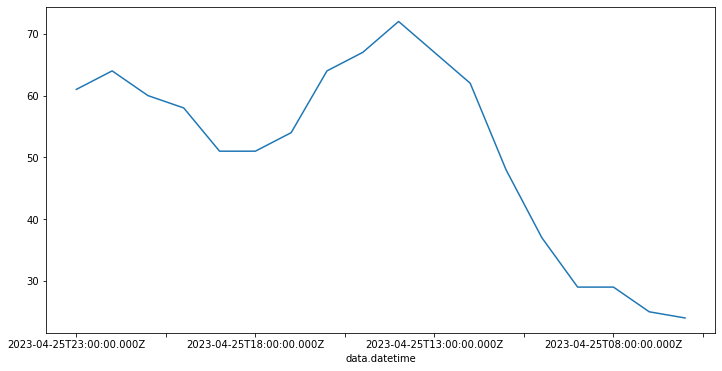

In [14]:
from subprocess import check_call, check_output

filepath = os.path.join("..", "data", "raw", "co2signal.com", "CA-ON", "latest.json")
history = check_output(["git", "log", "-p", "--follow", "--", filepath]).decode("utf-8").split("\n")
n_commits = len([i for i, line in enumerate(history) if line.startswith("diff --git a")])

data = []
for i in range(1, n_commits+1):
    check_call(["git", "checkout", f"HEAD~{i}", filepath])
    data.append(json.loads(open(filepath, "r").read()))
check_call(["git", "checkout", "HEAD", filepath])

df = pd.json_normalize(data).drop_duplicates()
df = df.set_index("data.datetime")
df["data.carbonIntensity"].plot()
df

In [15]:
for name in ["summary", "output", "capability"]:
    history_path = f"{name}.csv"
    latest_path = os.path.join("..", "data", "clean", "gridwatch.ca", "latest", f"{name}.json")
    df = load_file(history_path)
    df.index = [index.isoformat() for index in df.index]
    df.index.name = "datetime"
    with open(latest_path, "w") as f:
        f.write(json.dumps(df.reset_index().iloc[-1].to_dict(), indent=4))